In [1]:
# Get dataset
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"
!unzip -qq master.zip

--2022-03-29 13:40:03--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2022-03-29 13:40:03--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2022-03-29 13:40:03--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <

In [190]:
import pandas as pd
import torch, torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import IPython
import random
#transganformer

In [25]:
data_dir = "ESC-50-master"
df = pd.read_csv(data_dir + '/meta/esc50.csv')

train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [92]:
df.head

<bound method NDFrame.head of                filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]>

In [238]:
from torchaudio.transforms import AmplitudeToDB
class AudioProcessor():
  def load_file(path):
    return (torchaudio.load(path))
  

  def standardise(audio, channels, sample_rate, length):
    x,y = audio
    # Convert to standard number of channels
    if not x.shape[0] == channels:
      if channels == 1:
        x = x[:1,:]
      else:
        x = torch.cat([x, x])

    # Resample the audio to a standard sample rate
    if not y == sample_rate:
      x = transforms.Resample(y, sample_rate)(x[:,:])

    # Resize the audio
    rows, audio_length = x.shape
    length = y//1000 * length

    if audio_length > length:
      x = x[:,:length]
    else:
      pad_begin_len = random.randint(0, length - audio_length)
      pad_end_len = length - audio_length - pad_begin_len

      pad_begin = torch.zeros((rows, pad_begin_len))
      pad_end = torch.zeros((rows, pad_end_len))

      x = torch.cat((pad_begin, x, pad_end), 1)
    return (x,sample_rate)


  def time_shift(audio, shift_max):
    return (audio[0].roll(int(random.random() * shift_max * audio[0].shape[1])),audio[1])


  def get_dbmel_spec(audio, mels, fft, db, hop):
    x,y = audio
    spectrogram = transforms.MelSpectrogram(y, 
                                  fft, 
                                  hop, 
                                  mels)(x)

    return (transforms.AmplitudeToDB(db)(spectrogram))
  

  def mask(spectrogram, coverage, h_mask, v_mask):
    x,y,z = spectrogram.shape

    colour = spectrogram.mean()

    for mask in range(h_mask):
      spectrogram = transforms.FrequencyMasking(coverage*y)(spectrogram,colour)
    for mask in range(v_mask):
      spectrogram = transforms.TimeMasking(coverage*z)(spectrogram,colour)
    return spectrogram



In [244]:
# Define Dataset format
class AudioSpecDataset(Dataset):
  def __init__(self, df, data_dir, length=4000, 
               sample_rate=44100, channels=2, 
               shift=0.4, n_masks=2, mask_coverage=0.1):
    self.ap = AudioProcessor
    self.df = df
    self.data_dir = data_dir
    
    self.length = length
    self.sample_rate = sample_rate
    self.channels = channels
    self.shift = shift
    self.n_masks = n_masks
    self.mask_coverage = mask_coverage


  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = str(self.data_dir + "/audio/" + self.df.loc[idx, 'filename'])
    class_name = self.df.loc[idx, 'category']

    # Load and standardise audio files
    audio = self.ap.load_file(path=audio_file)
    audio = self.ap.standardise(audio, 
                                self.channels, 
                                self.sample_rate, 
                                self.length)

    # Augment audio
    audio = self.ap.time_shift(audio, self.shift)
    
    # Convert to spectrogram and mask
    spec = self.ap.get_dbmel_spec(audio, 
                                  mels=64, 
                                  fft=1024, 
                                  db=80, 
                                  hop=None)
    
    spec = self.ap.mask(spec, coverage=self.mask_coverage, 
                        h_mask=self.n_masks, v_mask=self.n_masks)

    return spec, class_name

In [191]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


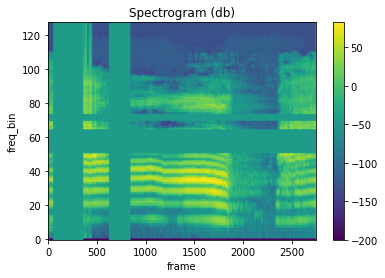

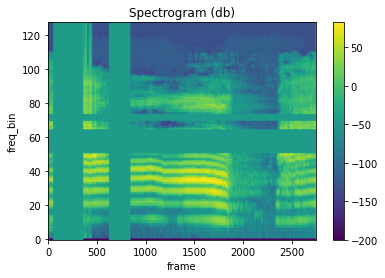

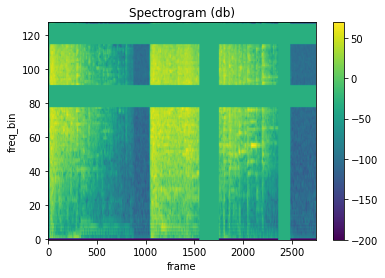

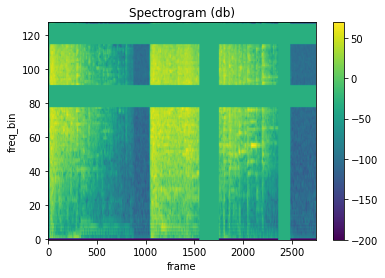

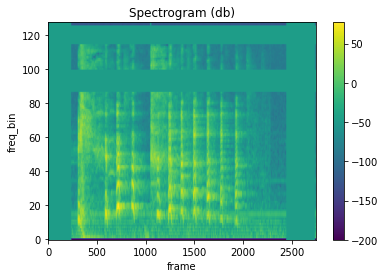

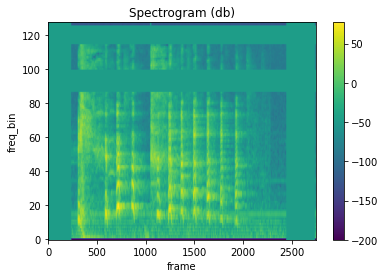

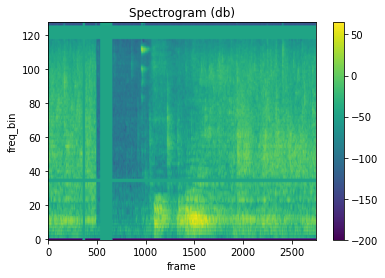

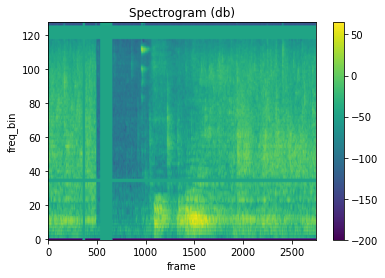

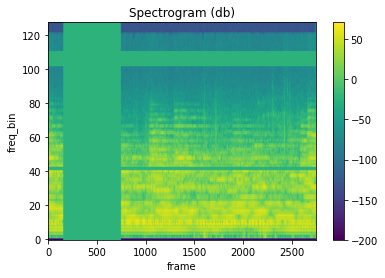

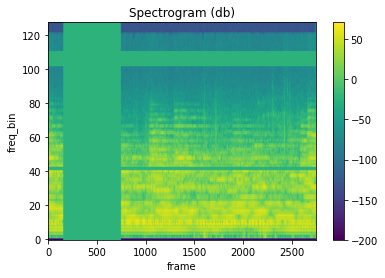

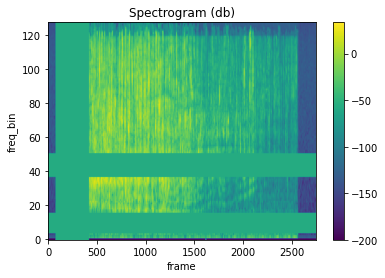

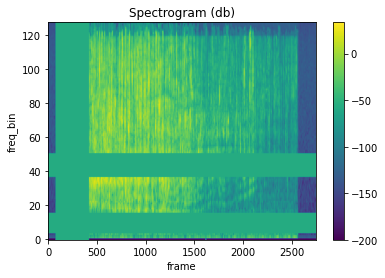

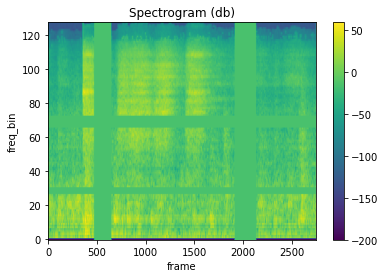

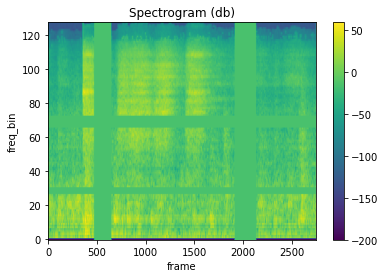

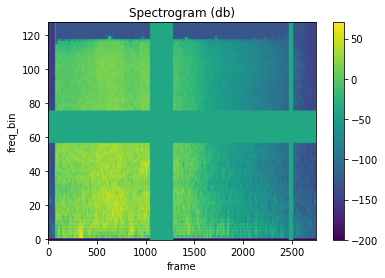

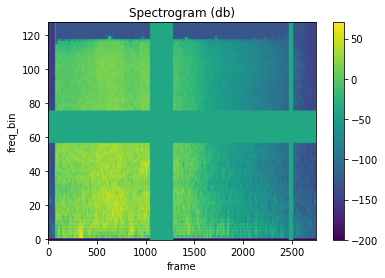

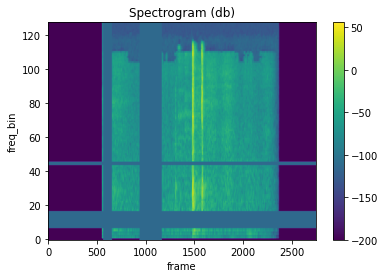

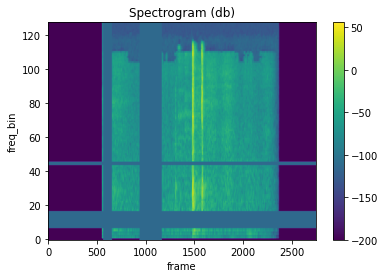

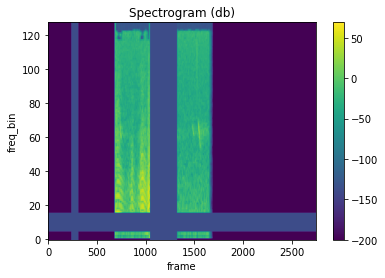

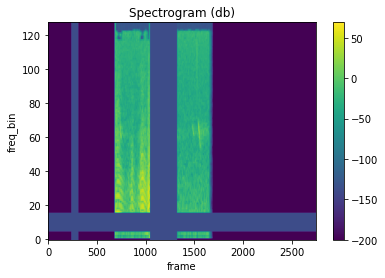

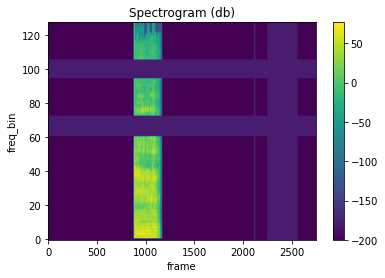

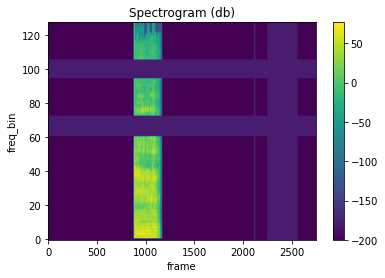

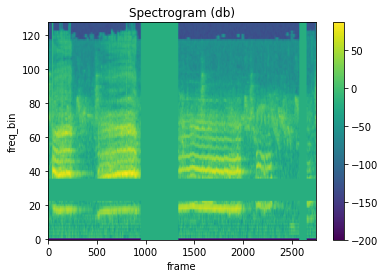

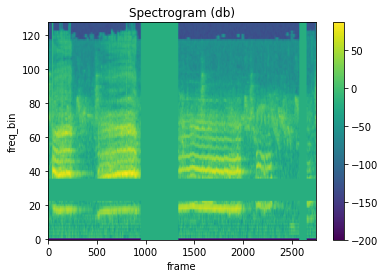

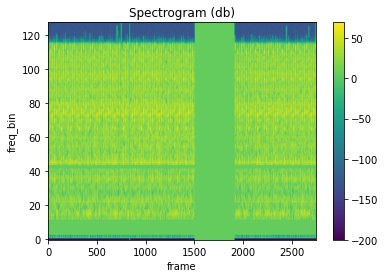

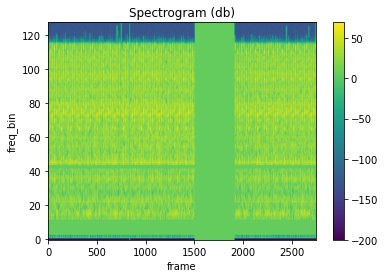

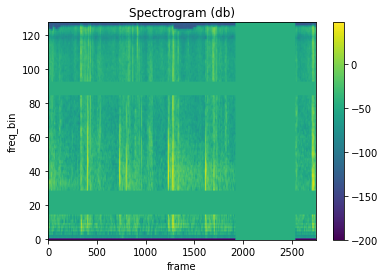

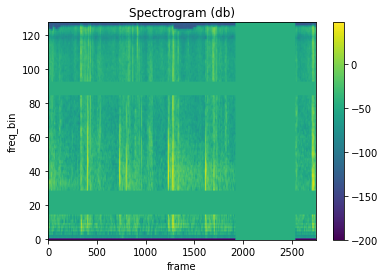

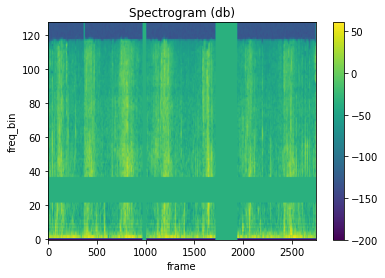

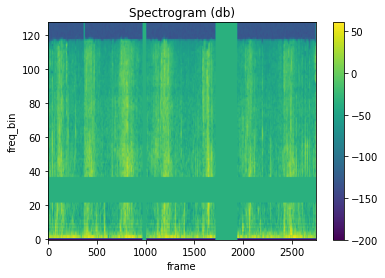

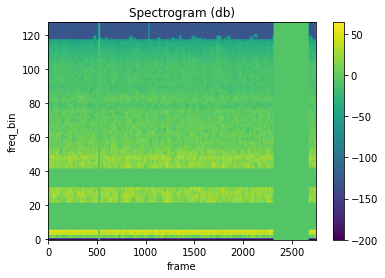

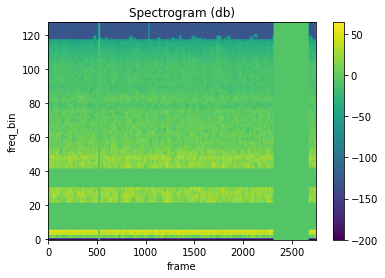

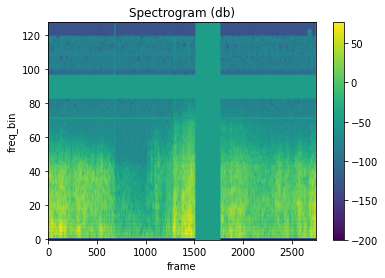

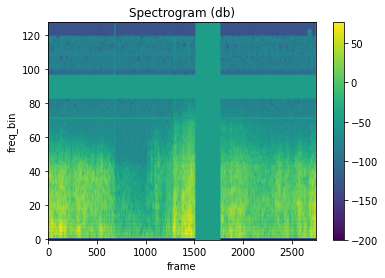

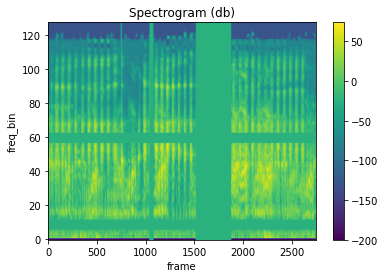

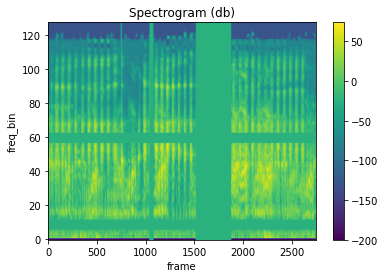

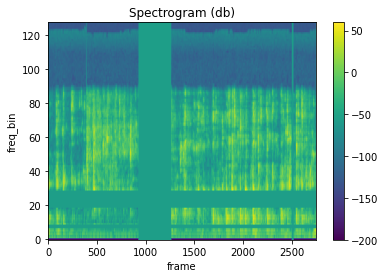

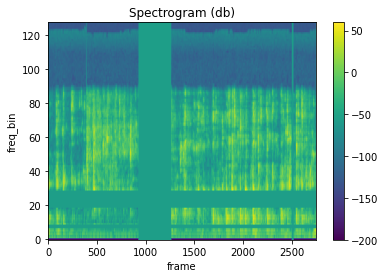

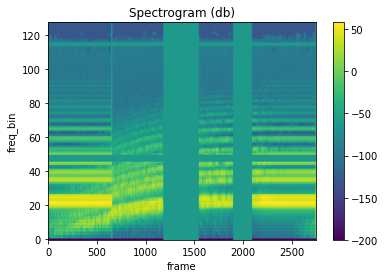

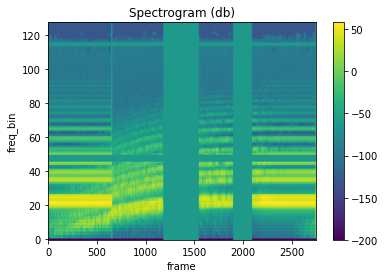

In [268]:
ds = AudioSpecDataset(df,data_dir, mask_coverage=0.15, n_masks=2)

for i in range(20):
  item = ds.__getitem__(random.randint(0,ds.__len__()))
  plot_spectrogram(item[0][0])
  plot_spectrogram(item[0][1])